{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# 🔄 Notebook Moved\n",
    "\n",
    "## This notebook has been consolidated into the Ultimate LLM Efficiency Analysis\n",
    "\n",
    "**Please use:** `ultimate_llm_efficiency_analysis.ipynb`\n",
    "\n",
    "The new notebook includes all clean analysis features plus:\n",
    "- ✅ Training analysis\n",
    "- ✅ Distillation analysis\n",
    "- ✅ Complete reporting\n",
    "- ✅ Standardized outputs\n",
    "\n",
    "**Location:** `/notebooks/ultimate_llm_efficiency_analysis.ipynb`"
   ]
  },

---

## 1. Setup and Data Loading

In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Paths
PROJECT_ROOT = Path('/home/amma/LLM-TIME')
EFFICIENCY_EXPERIMENTS_PATH = PROJECT_ROOT / 'efficiency_experiments'
RESULTS_PATH = Path('./efficiency_analysis_results')
RESULTS_PATH.mkdir(exist_ok=True)

# Import modules
sys.path.append(str(PROJECT_ROOT))

# Reload for latest changes
for module in ['enhanced_data_loader', 'analysis_utils', 'edge_analysis']:
    if module in sys.modules:
        importlib.reload(sys.modules[module])

from enhanced_data_loader import EnhancedEfficiencyDataLoader
from analysis_utils import calculate_inference_metrics, create_inference_plots, calculate_energy_metrics, generate_summary_report, create_detailed_comparison_table
from edge_analysis import assess_edge_compatibility, get_edge_recommendations

print("✅ Setup complete")

✅ Setup complete


In [2]:
# Load efficiency data
print("🔄 Loading efficiency data...")

loader = EnhancedEfficiencyDataLoader(EFFICIENCY_EXPERIMENTS_PATH)
efficiency_df = loader.parse_all_data()

print(f"\n📊 Dataset Overview:")
print(f"  • Total records: {len(efficiency_df)}")
print(f"  • Unique models: {efficiency_df['model_name'].nunique()}")
print(f"  • Models: {', '.join(efficiency_df['model_name'].unique())}")

# Data completeness check
timing_data = efficiency_df.dropna(subset=['avg_inference_time_ms'])
power_data = efficiency_df.dropna(subset=['inference_avg_power_w'])
print(f"  • Records with timing: {len(timing_data)}")
print(f"  • Records with power: {len(power_data)}")

🔄 Loading efficiency data...
🔍 Scanning for experiment files...
📊 Found 53 JSON files
📊 Processing 24 efficiency_reports...
📊 Processing 11 comprehensive_reports...
📊 Processing 18 real_performance_reports...
✅ Loaded 51 total records

📊 Dataset Overview:
  • Total records: 51
  • Unique models: 6
  • Models: chronos-t5-base, chronos-t5-tiny, LLAMA, GPT2, BERT, tinybert
  • Records with timing: 17
  • Records with power: 9


## 2. Inference Performance Analysis

In [3]:
# Inference performance analysis
print("⚡ Analyzing inference performance...")

# Filter inference data
inference_data = efficiency_df[
    (efficiency_df['report_type'].isin(['comprehensive_reports', 'real_performance_reports'])) |
    (efficiency_df['experiment_type'].str.contains('inference', na=False))
].copy()

# Calculate metrics
inference_summary = calculate_inference_metrics(inference_data)

# Display results
print(f"\n📊 Inference Performance Summary:")
display_cols = ['model_name', 'avg_inference_time_ms', 'inference_peak_ram_mb', 'inference_avg_power_w', 'edge_feasibility']
available_cols = [col for col in display_cols if col in inference_summary.columns]
print(inference_summary[available_cols].to_string(index=False))

print(f"\nInference records processed: {len(inference_data)}")
print(f"Models with complete metrics: {len(inference_summary)}")

⚡ Analyzing inference performance...

📊 Inference Performance Summary:
     model_name  avg_inference_time_ms  inference_peak_ram_mb  inference_avg_power_w edge_feasibility
chronos-t5-base            2558.052272            1088.334635             107.946905         feasible
chronos-t5-tiny            2277.259338            1073.126302              99.727776         feasible
          LLAMA          488356.303489           26149.840820             185.961041      challenging
           GPT2          311727.767871            2263.758789             175.197675         feasible
           BERT          208218.775673            2062.178711             164.152812         feasible
       tinybert            1271.302853             982.861979              55.221700         feasible

Inference records processed: 39
Models with complete metrics: 6


📊 Creating inference performance visualizations...
📊 Plot saved to: efficiency_analysis_results/inference_performance.png


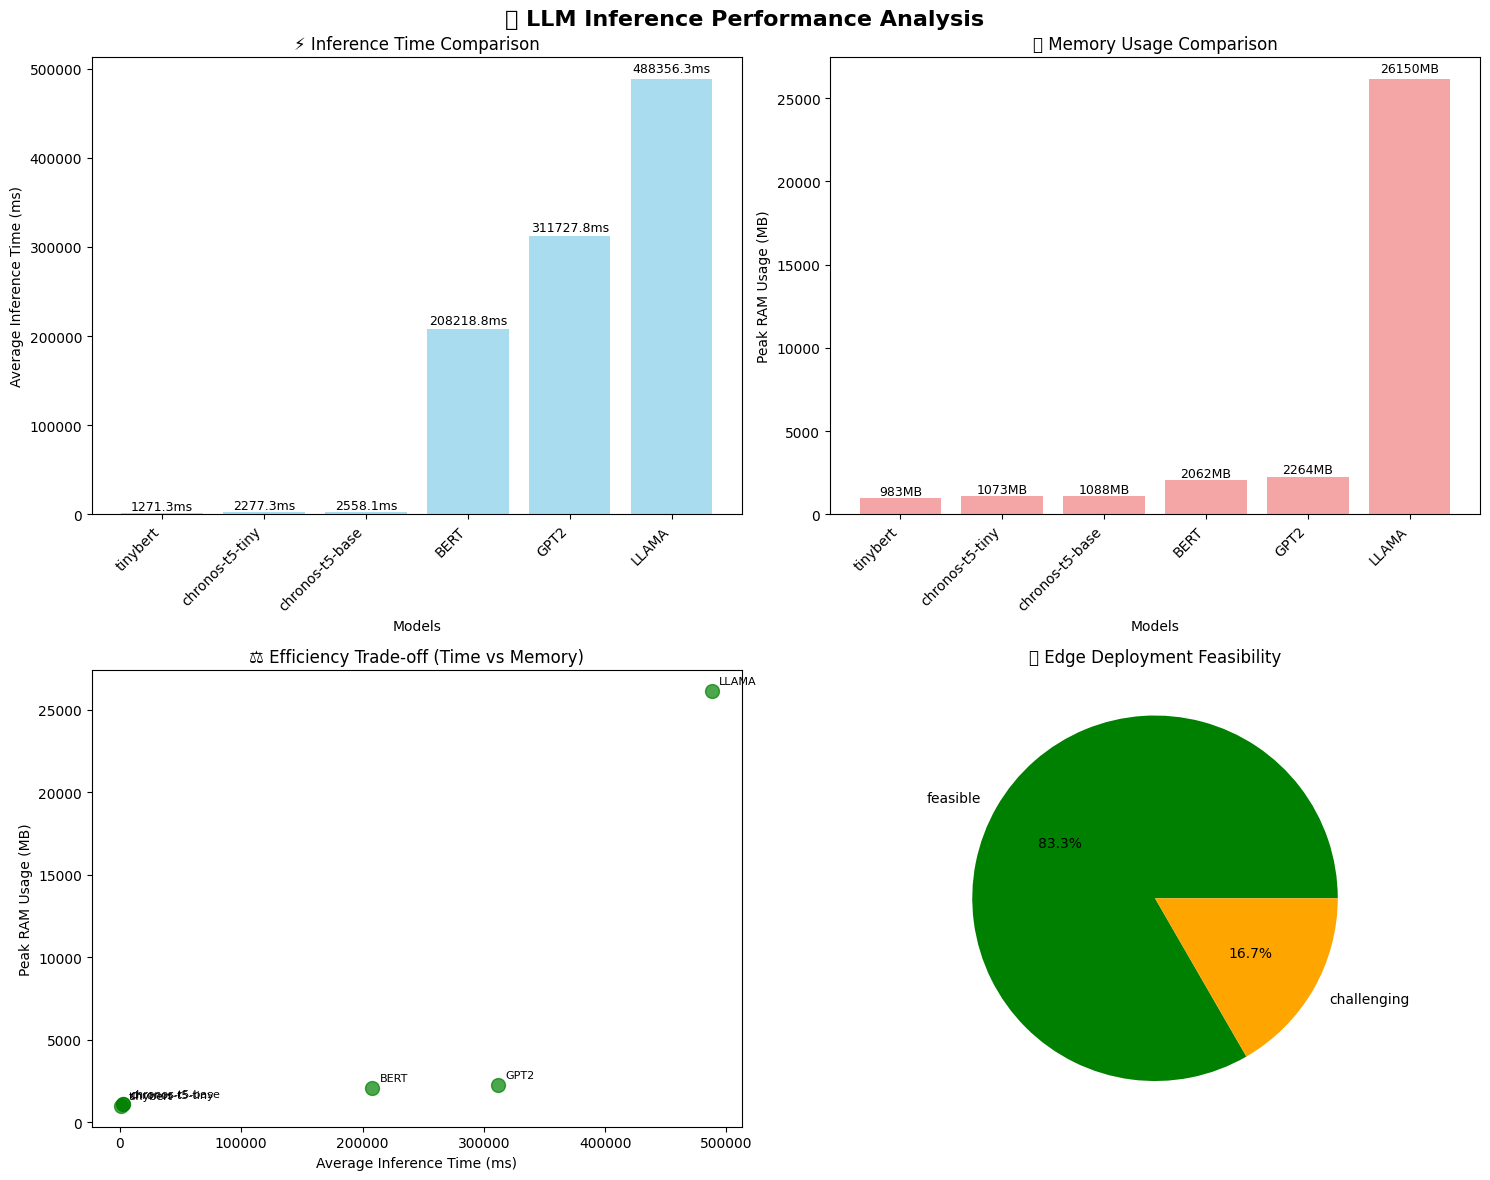

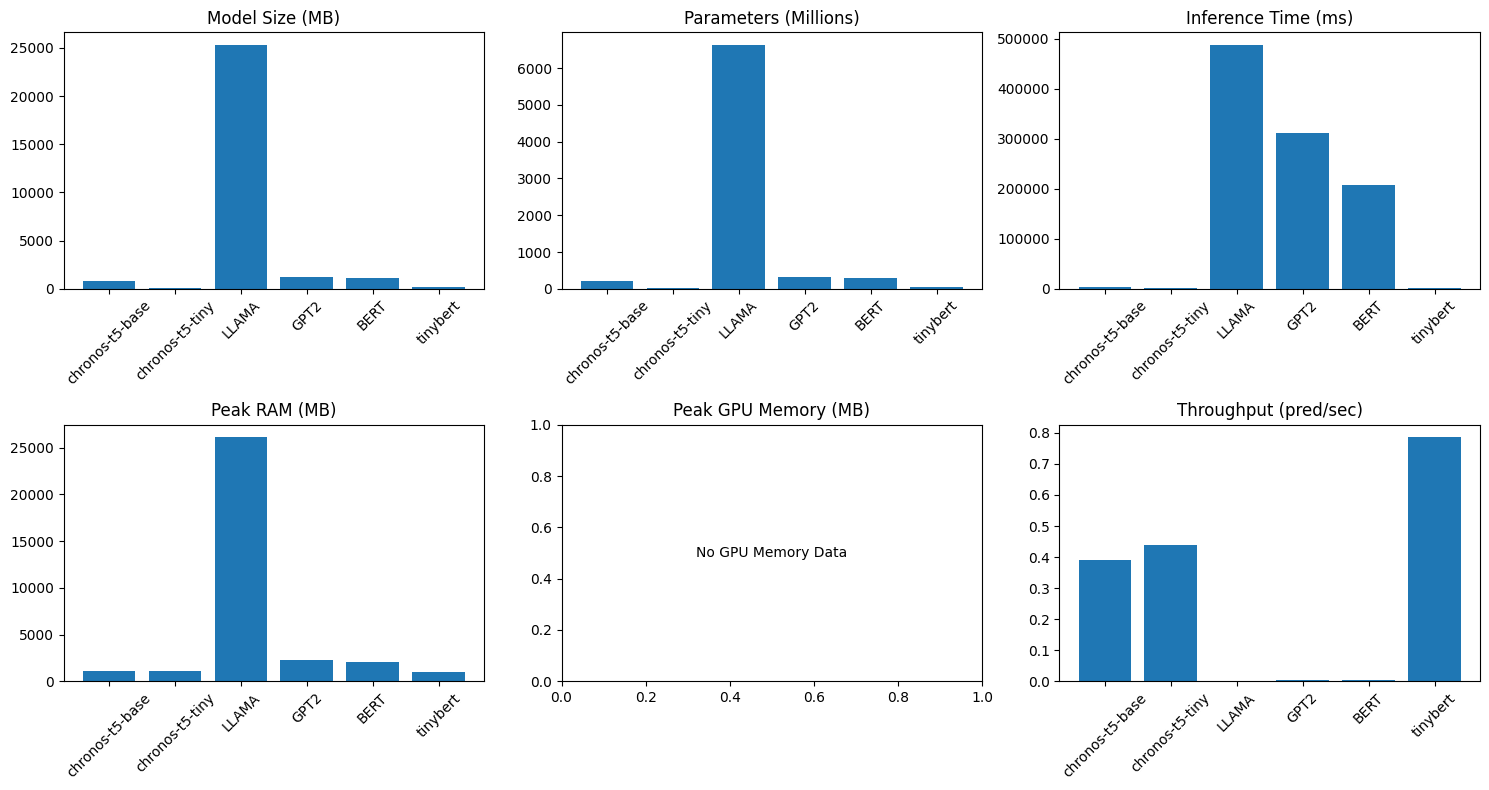

✅ Visualizations created


In [4]:
# Create visualizations
print("📊 Creating inference performance visualizations...")

create_inference_plots(inference_summary, str(RESULTS_PATH / 'inference_performance.png'))

print("✅ Visualizations created")

In [5]:
# Detailed performance comparison
print("📋 Creating detailed performance comparison...")

comparison_table = create_detailed_comparison_table(inference_summary)

print("\n📊 DETAILED MODEL COMPARISON:")
print("=" * 80)
print(comparison_table.to_string(index=False))

# Performance winners
if not comparison_table.empty:
    print(f"\n🏆 PERFORMANCE WINNERS:")
    
    # Fastest models
    if 'avg_inference_time_ms' in comparison_table.columns:
        fastest = comparison_table.loc[comparison_table['avg_inference_time_ms'].idxmin()]
        print(f"  ⚡ Fastest: {fastest['model_name']} ({fastest['avg_inference_time_ms']:.1f}ms)")
    
    # Memory efficient
    if 'inference_peak_ram_mb' in comparison_table.columns:
        memory_eff = comparison_table.loc[comparison_table['inference_peak_ram_mb'].idxmin()]
        print(f"  💾 Memory Efficient: {memory_eff['model_name']} ({memory_eff['inference_peak_ram_mb']:.1f}MB)")
    
    # Power efficient
    if 'inference_avg_power_w' in comparison_table.columns:
        power_eff = comparison_table.loc[comparison_table['inference_avg_power_w'].idxmin()]
        print(f"  🔋 Power Efficient: {power_eff['model_name']} ({power_eff['inference_avg_power_w']:.1f}W)")
    
    # Overall efficiency score
    required_cols = ['avg_inference_time_ms', 'inference_peak_ram_mb', 'inference_avg_power_w']
    if all(col in comparison_table.columns for col in required_cols):
        score_data = comparison_table.copy()
        
        # Normalize metrics (lower is better)
        score_data['time_score'] = score_data['avg_inference_time_ms'] / score_data['avg_inference_time_ms'].max()
        score_data['memory_score'] = score_data['inference_peak_ram_mb'] / score_data['inference_peak_ram_mb'].max()
        score_data['power_score'] = score_data['inference_avg_power_w'] / score_data['inference_avg_power_w'].max()
        score_data['overall_score'] = (score_data['time_score'] + score_data['memory_score'] + score_data['power_score']) / 3
        
        winner = score_data.loc[score_data['overall_score'].idxmin()]
        print(f"\n🥇 OVERALL WINNER: {winner['model_name']} (Score: {winner['overall_score']:.3f})")
        print(f"   Speed: {winner['avg_inference_time_ms']:.1f}ms | Memory: {winner['inference_peak_ram_mb']:.1f}MB | Power: {winner['inference_avg_power_w']:.1f}W")

📋 Creating detailed performance comparison...

📊 DETAILED MODEL COMPARISON:
     model_name  avg_inference_time_ms  inference_peak_ram_mb  inference_avg_power_w  total_parameters  model_size_mb  throughput_predictions_per_sec edge_feasibility
       tinybert                1271.30                 982.86                  55.22          44998814         171.66                            0.79         feasible
chronos-t5-tiny                2277.26                1073.13                  99.73           8394496          32.02                            0.44         feasible
chronos-t5-base                2558.05                1088.33                 107.95         201374976         768.18                            0.39         feasible
           BERT              208218.78                2062.18                 164.15         282363198        1077.13                            0.00         feasible
           GPT2              311727.77                2263.76                 175.20     

## 3. Edge Deployment Assessment

In [6]:
# Edge deployment compatibility assessment
print("📱 Analyzing edge deployment compatibility...")

edge_assessment = assess_edge_compatibility(inference_summary)
recommendations = get_edge_recommendations(edge_assessment)

print(f"\n🎯 Edge Deployment Summary:")
for model_name in inference_summary['model_name'].unique():
    model_compatible = edge_assessment[edge_assessment['model_name'] == model_name]['compatible'].sum()
    total_devices = len(edge_assessment[edge_assessment['model_name'] == model_name])
    print(f"  • {model_name}: {model_compatible}/{total_devices} devices compatible")

print(f"\n🏆 Device Recommendations:")
for model_name, recs in recommendations.items():
    if recs:
        best_device = recs[0]
        print(f"  • {model_name}: {best_device['device_name']} (${best_device['device_cost_usd']})")
    else:
        print(f"  • {model_name}: No suitable devices found")

# Save results
edge_assessment.to_csv(RESULTS_PATH / 'edge_compatibility_assessment.csv', index=False)
print(f"\n💾 Results saved to: {RESULTS_PATH / 'edge_compatibility_assessment.csv'}")

📱 Analyzing edge deployment compatibility...

🎯 Edge Deployment Summary:
  • chronos-t5-base: 5/5 devices compatible
  • chronos-t5-tiny: 5/5 devices compatible
  • LLAMA: 0/5 devices compatible
  • GPT2: 4/5 devices compatible
  • BERT: 4/5 devices compatible
  • tinybert: 5/5 devices compatible

🏆 Device Recommendations:
  • chronos-t5-base: Intel NUC i5 ($600)
  • chronos-t5-tiny: Intel NUC i5 ($600)
  • LLAMA: No suitable devices found
  • GPT2: Intel NUC i5 ($600)
  • BERT: Intel NUC i5 ($600)
  • tinybert: Intel NUC i5 ($600)

💾 Results saved to: efficiency_analysis_results/edge_compatibility_assessment.csv


## 4. Energy and Sustainability Analysis

In [7]:
# Energy efficiency analysis
print("🌱 Analyzing energy efficiency and sustainability...")

energy_metrics = calculate_energy_metrics(inference_summary)

if not energy_metrics.empty:
    print(f"\n🔋 Energy Efficiency Summary:")
    print(energy_metrics.to_string(index=False))
    
    # Most energy efficient
    most_efficient = energy_metrics.loc[energy_metrics['energy_per_prediction_wh'].idxmin()]
    print(f"\n🏆 Most Energy Efficient: {most_efficient['model_name']}")
    print(f"   Energy per prediction: {most_efficient['energy_per_prediction_wh']:.6f} Wh")
    print(f"   Carbon footprint: {most_efficient['carbon_per_prediction_g']:.8f} g CO₂")
    print(f"   Annual carbon footprint: {most_efficient['annual_carbon_footprint_kg']:.2f} kg CO₂")
    
    # Save results
    energy_metrics.to_csv(RESULTS_PATH / 'energy_sustainability_analysis.csv', index=False)
    print(f"\n💾 Energy analysis saved to: {RESULTS_PATH / 'energy_sustainability_analysis.csv'}")
else:
    print("⚠️ No power consumption data available for energy analysis")

🌱 Analyzing energy efficiency and sustainability...

🔋 Energy Efficiency Summary:
     model_name  energy_per_prediction_wh  carbon_per_prediction_g  daily_energy_consumption_wh  annual_carbon_footprint_kg
chronos-t5-base                  0.076704                 0.038352                    76.703841                   13.998451
chronos-t5-tiny                  0.063085                 0.031543                    63.085003                   11.513013
          LLAMA                 25.226457                12.613229                 25226.457354                 4603.828467
           GPT2                 15.170550                 7.585275                 15170.550003                 2768.625376
           BERT                  9.494360                 4.747180                  9494.360427                 1732.720778
       tinybert                  0.019501                 0.009750                    19.500974                    3.558928

🏆 Most Energy Efficient: tinybert
   Energy per p

## 5. Final Summary Report

In [8]:
# Generate final summary report
print("📋 Generating comprehensive summary report...")

summary_report = generate_summary_report(efficiency_df, inference_summary)

# Save report
report_file = RESULTS_PATH / 'efficiency_summary_report.md'
with open(report_file, 'w') as f:
    f.write(summary_report)

print(f"📄 Summary report saved to: {report_file}")

# Final key findings
print(f"\n" + "="*80)
print(f"🎯 FINAL ANALYSIS SUMMARY")
print(f"="*80)

complete_data = inference_summary.dropna(subset=['avg_inference_time_ms', 'inference_peak_ram_mb'])
print(f"\n📊 Analysis Results:")
print(f"  • Total models analyzed: {len(inference_summary)}")
print(f"  • Models with complete metrics: {len(complete_data)}")
print(f"  • Total data records processed: {len(efficiency_df)}")

if not complete_data.empty:
    fastest = complete_data.loc[complete_data['avg_inference_time_ms'].idxmin()]
    most_efficient = complete_data.loc[complete_data['inference_peak_ram_mb'].idxmin()]
    
    print(f"\n🏆 Top Performers:")
    print(f"  ⚡ Fastest: {fastest['model_name']} ({fastest['avg_inference_time_ms']:.1f}ms)")
    print(f"  💾 Memory Efficient: {most_efficient['model_name']} ({most_efficient['inference_peak_ram_mb']:.1f}MB)")

# Edge deployment summary
if 'edge_feasibility' in inference_summary.columns:
    feasibility_counts = inference_summary['edge_feasibility'].value_counts()
    print(f"\n📱 Edge Deployment Readiness:")
    for category, count in feasibility_counts.items():
        emoji_map = {"highly_feasible": "🟢", "feasible": "🟡", "challenging": "🔴", "unknown": "⚪"}
        emoji = emoji_map.get(str(category), "🔘")
        category_str = str(category).replace('_', ' ').title()
        print(f"  {emoji} {category_str}: {count} models")

print(f"\n✅ Analysis complete! All results saved to: {RESULTS_PATH}")
print(f"\n📁 Generated files:")
for file_path in sorted(RESULTS_PATH.glob('*')):
    print(f"  - {file_path.name}")

📋 Generating comprehensive summary report...
📄 Summary report saved to: efficiency_analysis_results/efficiency_summary_report.md

🎯 FINAL ANALYSIS SUMMARY

📊 Analysis Results:
  • Total models analyzed: 6
  • Models with complete metrics: 6
  • Total data records processed: 51

🏆 Top Performers:
  ⚡ Fastest: tinybert (1271.3ms)
  💾 Memory Efficient: tinybert (982.9MB)

📱 Edge Deployment Readiness:
  🟡 Feasible: 5 models
  🔴 Challenging: 1 models

✅ Analysis complete! All results saved to: efficiency_analysis_results

📁 Generated files:
  - comprehensive_efficiency_report.md
  - edge_compatibility_assessment.csv
  - edge_deployment_assessment.csv
  - edge_deployment_assessment.png
  - efficiency_summary_report.md
  - energy_analysis.csv
  - energy_consumption_analysis.csv
  - energy_consumption_analysis.png
  - energy_sustainability_analysis.csv
  - inference_performance.png
  - raw_efficiency_data.csv
  - training_performance_analysis.png
  - training_summary.csv
